# Autoencoder
* https://medium.com/ai-academy-taiwan/what-are-autoencoders-175b474d74d1
* https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/
* https://github.com/MorvanZhou/tutorials/blob/master/kerasTUT/9-Autoencoder_example.py

In [1]:
# Basic import
import os
import sys
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [3]:
from keras.models import Model
from keras.layers import Dense, Input
from keras import backend as K
from keras.callbacks import EarlyStopping

from sklearn import cluster, datasets, metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/py

# Load data

In [4]:
df = pd.read_csv('./input/followingMatrix_over1.csv')
df

,movie,20thcenturyfox,a24,accessonline,adamsandler,adamshankman,agt,aldis_hodge,alecbaldwininsta,alexandrashipppp,...,willpowerpacker,willsmith,wmag,woodyharrelson,wwe,yahooentertainment,zacefron,zaziebeetz,zendaya,zoeydeutch
0,21bridgesmovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47metersdown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abeautifuldaymovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abominablemovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,adastramovie,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161,xmenmovies,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
162,yardiefilm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,yesterdaymovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_li = []
y_li = []
for i, row in df.iterrows():
    y_li.append(row['movie'])
    x_li.append(row.iloc[1:].tolist())
    
x = np.asarray(x_li)
y = np.asarray(y_li)
print(x.shape, y.shape)

(165, 472) (165,)


In [6]:
from sklearn.preprocessing import MinMaxScaler
print(x)
scaler = MinMaxScaler()
scaler.fit(x)
train_scaled = scaler.transform(x)
print(train_scaled.shape)
print(train_scaled)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
(165, 472)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(train_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(132, 472) (33, 472)
(132,) (33,)


In [8]:
input_vec = x.shape[1]

In [15]:
def training(middle_dim, encoding_dim):
    # save setting
    SAVE_NAME = str(middle_dim) + '-' + str(encoding_dim) + 'dim'
    print(SAVE_NAME)
    HISTORY_SAVE = './history/grid/' + SAVE_NAME + '.csv'
    WEIGHTS_SAVE = './weight/grid/' + SAVE_NAME + '.h5'
    
    K.clear_session()
    # model setting
    input_dim = Input(shape = (input_vec, ))

    # Encoder Layers
    encoded1 = Dense(middle_dim, activation = 'relu')(input_dim)
    encoded2 = Dense(encoding_dim, activation = 'relu')(encoded1)

    # Decoder Layers
    decoded1 = Dense(middle_dim, activation = 'relu')(encoded2)
    decoded2 = Dense(input_vec, activation = 'sigmoid')(decoded1)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded2)
    autoencoder.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
    
    autoencoder.summary()

    # start training
    callbacks = [EarlyStopping(monitor='val_loss')]
    history = autoencoder.fit(X_train, X_train, epochs = 100, batch_size = 50, 
                              validation_data = (X_test, X_test),shuffle = True, callbacks=callbacks)
    
    # save weight
    autoencoder.save(WEIGHTS_SAVE)
    
    # save history
    # acc = history.history['acc']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    his_df = pd.DataFrame(data = {
        'Epoch' : epochs,
        'Loss' : loss,
    #     'Acc' : acc,
        'Val_loss' : val_loss#,
    #     'Val_acc' : val_acc
    })
    his_df = his_df[['Epoch', 'Loss','Val_loss']]
    his_df.to_csv(HISTORY_SAVE, index = False)
    
    
    # encoding feature
    encoder = Model(inputs = input_dim, outputs = encoded2)

    encoded_train = pd.DataFrame(encoder.predict(train_scaled))
    userContent=np.array(encoded_train)

    encoded_train = encoded_train.add_prefix('feature_')
    print(encoded_train.shape)

    # save dataframe
    encoded_train['movie'] = df['movie']
    encoded_train = encoded_train.set_index('movie')
    encoded_train.to_csv('./output/grid/' + SAVE_NAME + '.csv')
    
    # silhouette part
    silhouette_avgs = []
    ks = range(2, 30)

    for k in ks:
        kmeans_fit = cluster.KMeans(n_clusters = k).fit(encoded_train)
        cluster_labels = kmeans_fit.labels_
        silhouette_avg = metrics.silhouette_score(train_scaled, cluster_labels)
        silhouette_avgs.append(silhouette_avg)

    # 作圖並印出 k = 2 到 30 的績效
    plt.bar(ks, silhouette_avgs)
    plt.show()
    write_json(silhouette_avgs, './score/grid/' + SAVE_NAME + '.json')
    
    # cosine_similarity part
    cos = cosine_similarity(encoded_train)
#     print(cos.shape)
    
    cos_df = pd.DataFrame(cos, index = df['movie'], columns = df['movie'])
    cos_df.to_csv('./cosine_similarity/grid/' + SAVE_NAME + '_cos.csv')
    print('==================================================')

In [10]:
search_list = [i for i in range(400, 0, -10)]
# search_list

210-200dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               42200     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               42210     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 283,332
Trainable params: 283,332
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.690

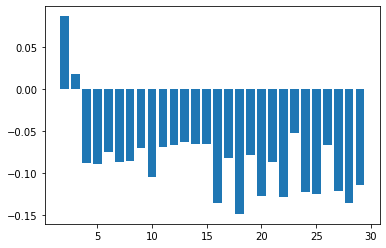

210-190dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 190)               40090     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               40110     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 279,122
Trainable params: 279,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

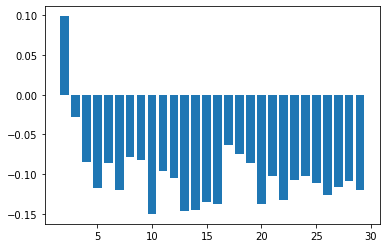

210-180dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 180)               37980     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               38010     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 274,912
Trainable params: 274,912
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.688

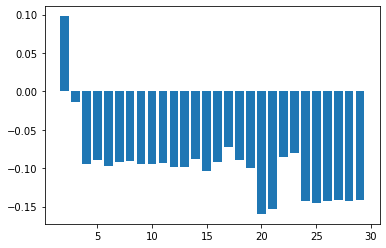

210-170dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 170)               35870     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               35910     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 270,702
Trainable params: 270,702
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

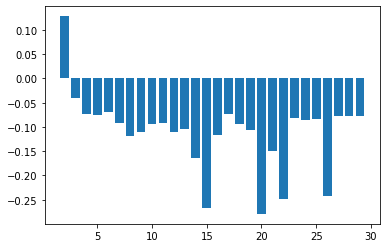

210-160dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               33760     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               33810     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 266,492
Trainable params: 266,492
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

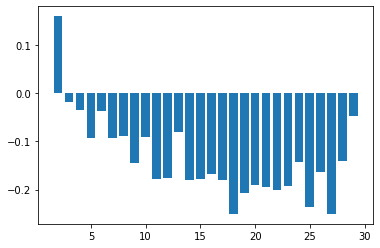

210-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               31650     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               31710     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 262,282
Trainable params: 262,282
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

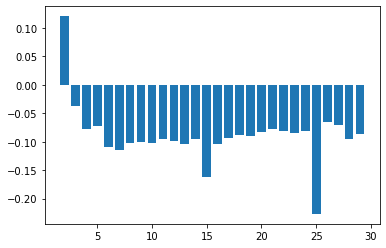

210-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               29540     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               29610     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 258,072
Trainable params: 258,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

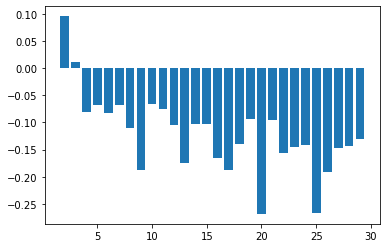

210-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               27430     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               27510     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 253,862
Trainable params: 253,862
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

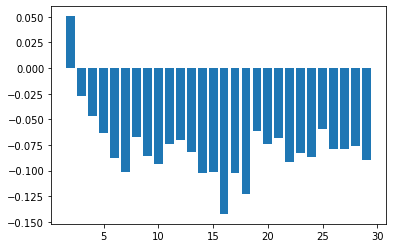

210-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               25320     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               25410     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 249,652
Trainable params: 249,652
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

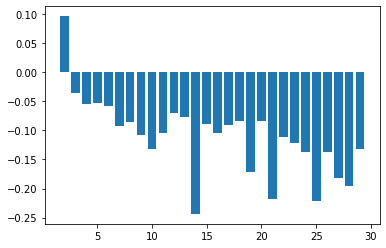

210-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               23210     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               23310     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 245,442
Trainable params: 245,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

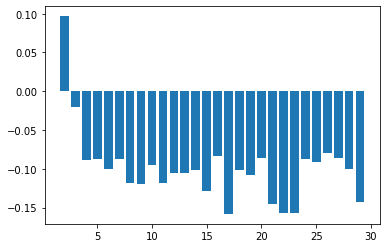

210-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               21100     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               21210     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 241,232
Trainable params: 241,232
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

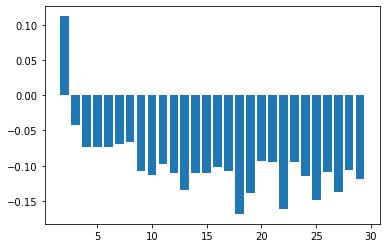

210-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                18990     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               19110     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 237,022
Trainable params: 237,022
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

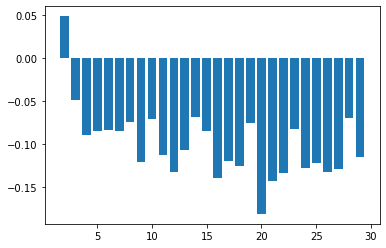

210-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                16880     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               17010     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 232,812
Trainable params: 232,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

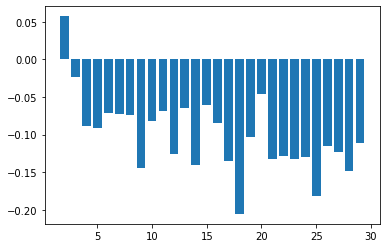

210-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                14770     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               14910     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 228,602
Trainable params: 228,602
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6901

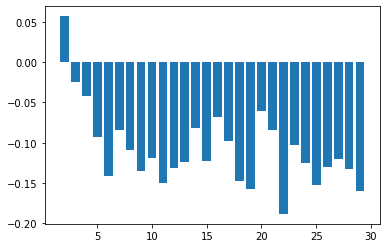

210-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                12660     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               12810     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 224,392
Trainable params: 224,392
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6905

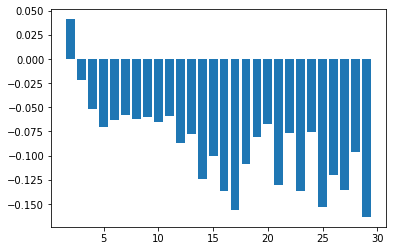

210-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10550     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               10710     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 220,182
Trainable params: 220,182
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

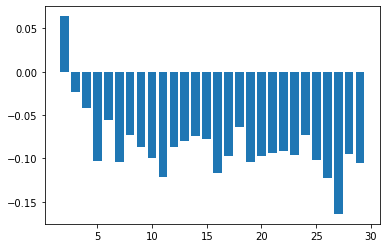

210-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                8440      
_________________________________________________________________
dense_3 (Dense)              (None, 210)               8610      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 215,972
Trainable params: 215,972
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6913

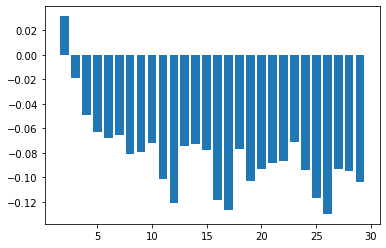

210-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                6330      
_________________________________________________________________
dense_3 (Dense)              (None, 210)               6510      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 211,762
Trainable params: 211,762
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

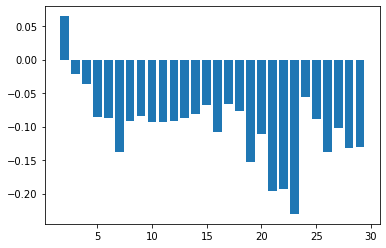

210-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4220      
_________________________________________________________________
dense_3 (Dense)              (None, 210)               4410      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 207,552
Trainable params: 207,552
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

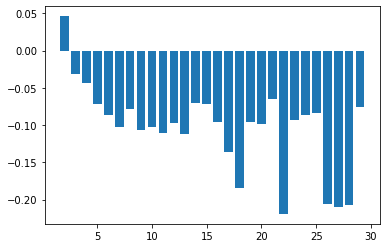

210-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 210)               99330     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2110      
_________________________________________________________________
dense_3 (Dense)              (None, 210)               2310      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               99592     
Total params: 203,342
Trainable params: 203,342
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923

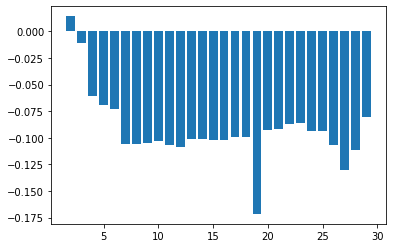

200-190dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 190)               38190     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               38200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 265,862
Trainable params: 265,862
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

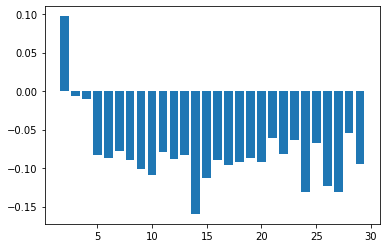

200-180dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 180)               36180     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               36200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 261,852
Trainable params: 261,852
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

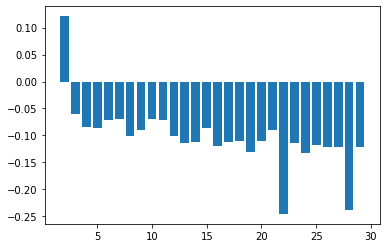

200-170dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 170)               34170     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               34200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 257,842
Trainable params: 257,842
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

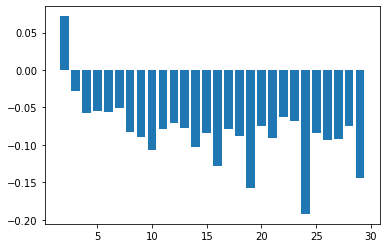

200-160dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               32160     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               32200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 253,832
Trainable params: 253,832
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

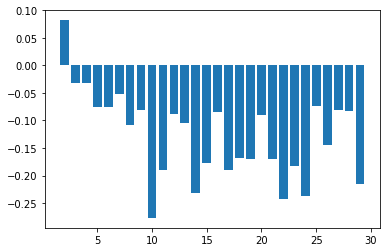

200-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               30200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 249,822
Trainable params: 249,822
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.690

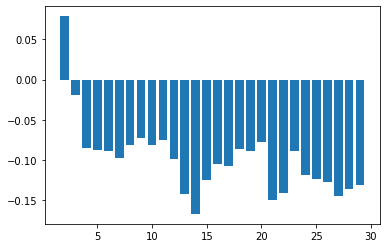

200-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               28140     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               28200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 245,812
Trainable params: 245,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

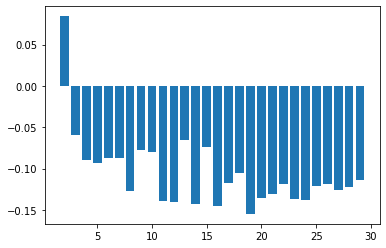

200-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               26130     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               26200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 241,802
Trainable params: 241,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

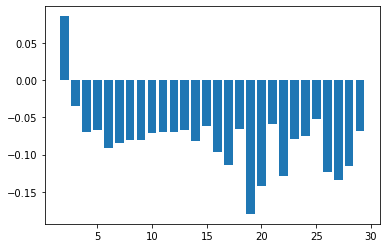

200-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               24120     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               24200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 237,792
Trainable params: 237,792
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

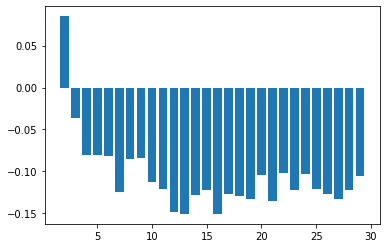

200-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               22110     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               22200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 233,782
Trainable params: 233,782
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

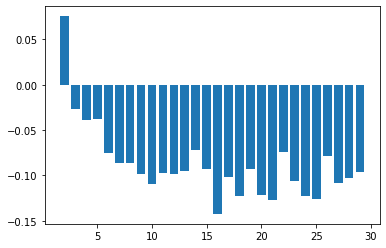

200-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 229,772
Trainable params: 229,772
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

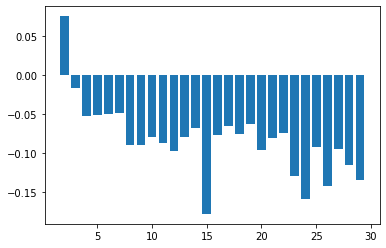

200-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                18090     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               18200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 225,762
Trainable params: 225,762
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6913

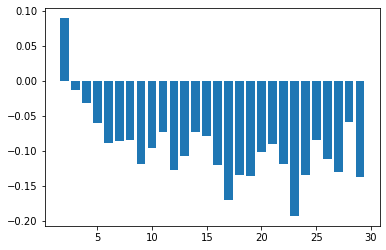

200-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                16080     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               16200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 221,752
Trainable params: 221,752
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6901

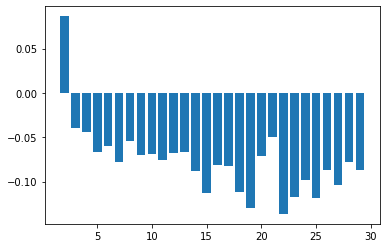

200-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                14070     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               14200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 217,742
Trainable params: 217,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6907

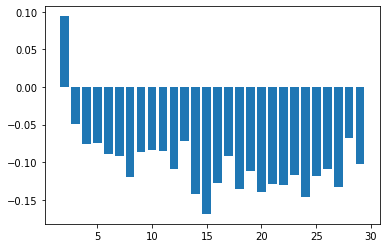

200-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                12060     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               12200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 213,732
Trainable params: 213,732
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

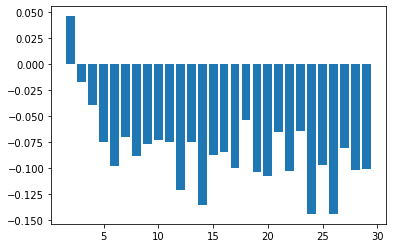

200-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 209,722
Trainable params: 209,722
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6911

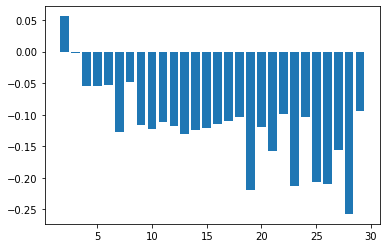

200-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               8200      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 205,712
Trainable params: 205,712
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6910

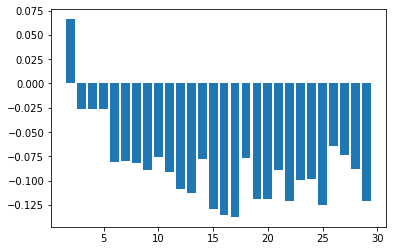

200-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               6200      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 201,702
Trainable params: 201,702
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

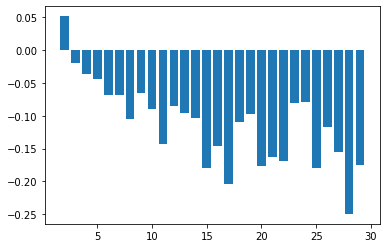

200-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               4200      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 197,692
Trainable params: 197,692
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

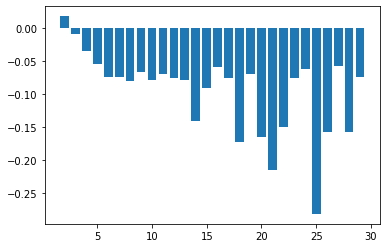

200-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               94600     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               94872     
Total params: 193,682
Trainable params: 193,682
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6925

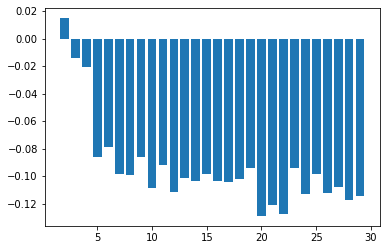

190-180dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 180)               34380     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               34390     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 248,792
Trainable params: 248,792
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

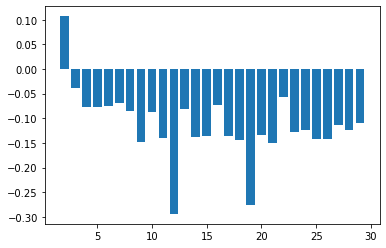

190-170dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 170)               32470     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               32490     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 244,982
Trainable params: 244,982
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

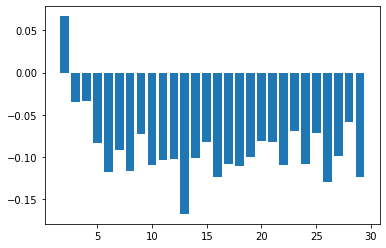

190-160dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               30560     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               30590     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 241,172
Trainable params: 241,172
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

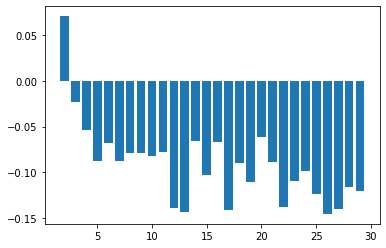

190-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               28650     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               28690     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 237,362
Trainable params: 237,362
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

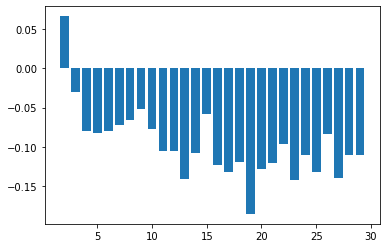

190-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               26740     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               26790     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 233,552
Trainable params: 233,552
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

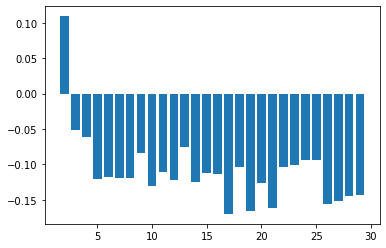

190-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               24830     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               24890     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 229,742
Trainable params: 229,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

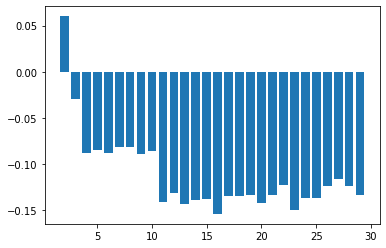

190-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               22920     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               22990     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 225,932
Trainable params: 225,932
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

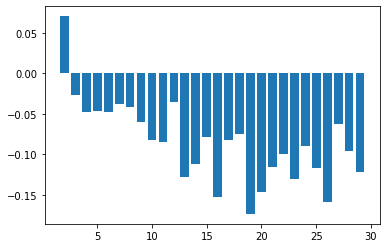

190-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               21010     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               21090     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 222,122
Trainable params: 222,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.690

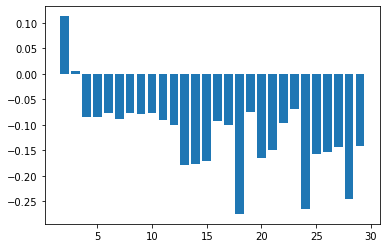

190-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               19100     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               19190     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 218,312
Trainable params: 218,312
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

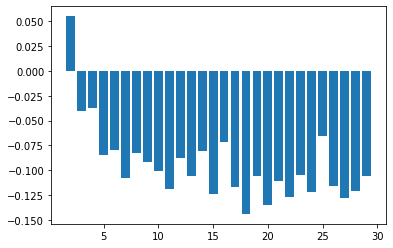

190-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                17190     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               17290     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 214,502
Trainable params: 214,502
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6913

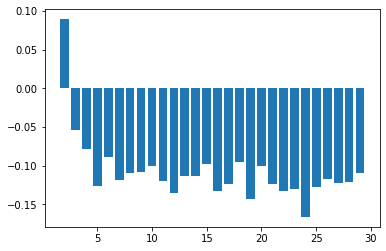

190-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                15280     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               15390     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 210,692
Trainable params: 210,692
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921

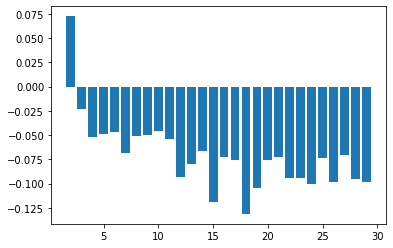

190-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                13370     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               13490     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 206,882
Trainable params: 206,882
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

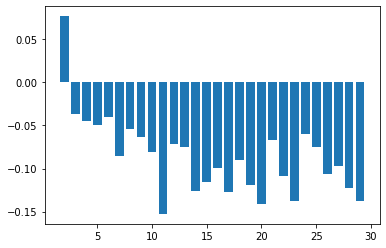

190-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                11460     
_________________________________________________________________
dense_3 (Dense)              (None, 190)               11590     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 203,072
Trainable params: 203,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6919

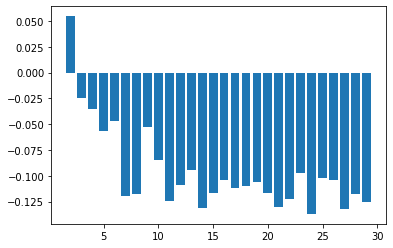

190-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                9550      
_________________________________________________________________
dense_3 (Dense)              (None, 190)               9690      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 199,262
Trainable params: 199,262
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6911

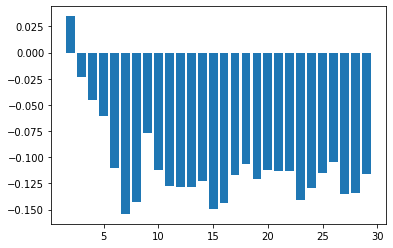

190-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                7640      
_________________________________________________________________
dense_3 (Dense)              (None, 190)               7790      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 195,452
Trainable params: 195,452
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6906

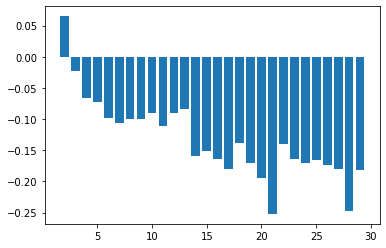

190-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                5730      
_________________________________________________________________
dense_3 (Dense)              (None, 190)               5890      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 191,642
Trainable params: 191,642
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920

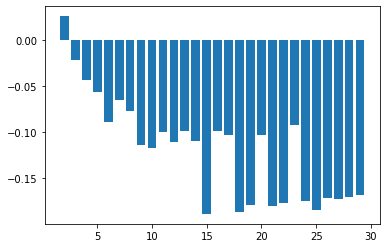

190-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3820      
_________________________________________________________________
dense_3 (Dense)              (None, 190)               3990      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 187,832
Trainable params: 187,832
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6916

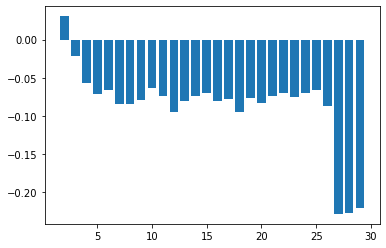

190-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               89870     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1910      
_________________________________________________________________
dense_3 (Dense)              (None, 190)               2090      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               90152     
Total params: 184,022
Trainable params: 184,022
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

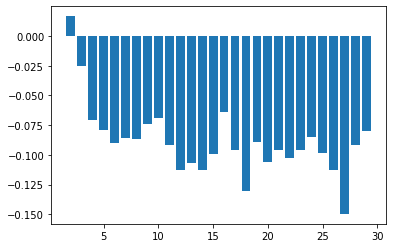

180-170dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 170)               30770     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               30780     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 232,122
Trainable params: 232,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.691

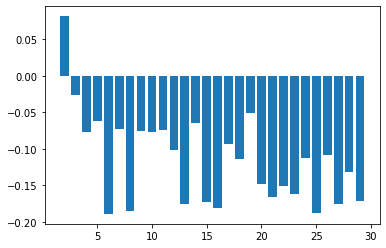

180-160dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               28960     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               28980     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 228,512
Trainable params: 228,512
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

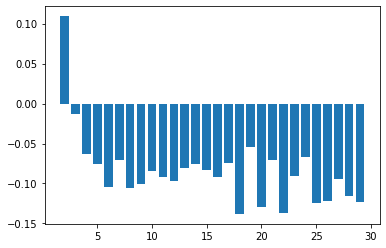

180-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               27150     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               27180     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 224,902
Trainable params: 224,902
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

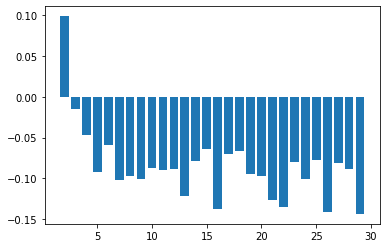

180-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               25340     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               25380     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 221,292
Trainable params: 221,292
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

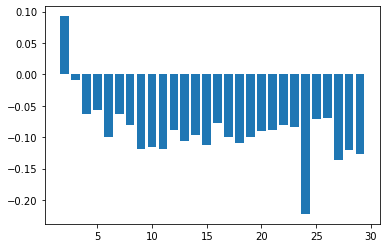

180-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               23530     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               23580     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 217,682
Trainable params: 217,682
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

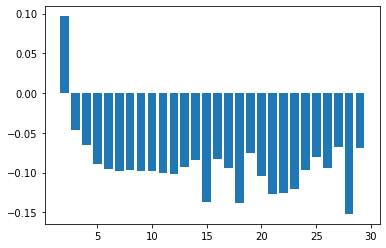

180-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               21720     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               21780     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 214,072
Trainable params: 214,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

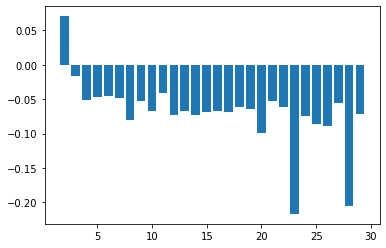

180-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               19910     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               19980     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 210,462
Trainable params: 210,462
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.689

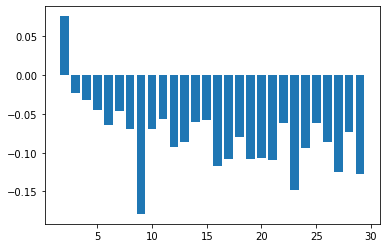

180-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               18180     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 206,852
Trainable params: 206,852
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

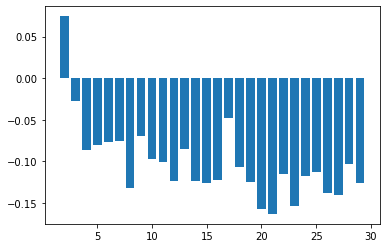

180-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                16290     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               16380     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 203,242
Trainable params: 203,242
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

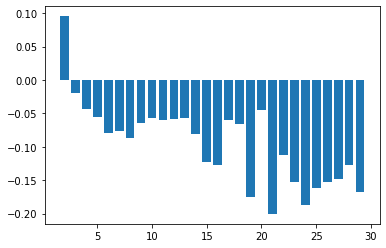

180-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                14480     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               14580     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 199,632
Trainable params: 199,632
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6903

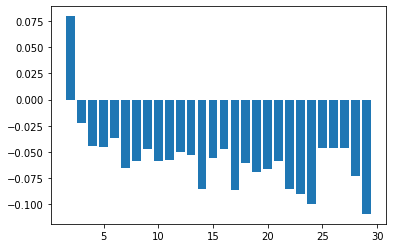

180-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                12670     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               12780     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 196,022
Trainable params: 196,022
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

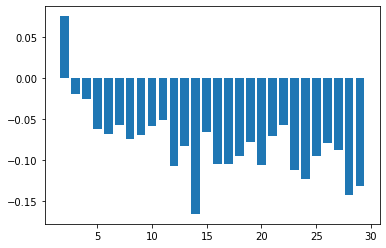

180-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                10860     
_________________________________________________________________
dense_3 (Dense)              (None, 180)               10980     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 192,412
Trainable params: 192,412
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6904

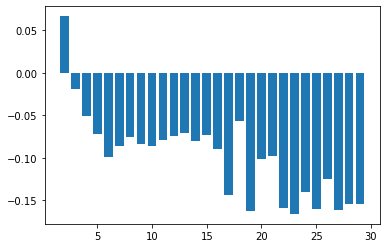

180-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                9050      
_________________________________________________________________
dense_3 (Dense)              (None, 180)               9180      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 188,802
Trainable params: 188,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

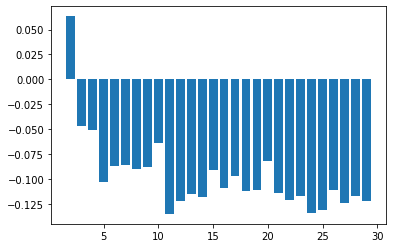

180-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                7240      
_________________________________________________________________
dense_3 (Dense)              (None, 180)               7380      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 185,192
Trainable params: 185,192
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6907

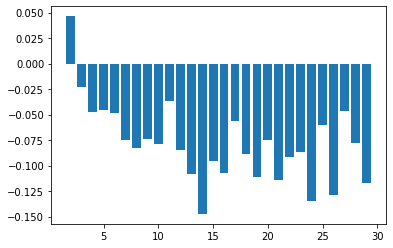

180-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                5430      
_________________________________________________________________
dense_3 (Dense)              (None, 180)               5580      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 181,582
Trainable params: 181,582
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6916

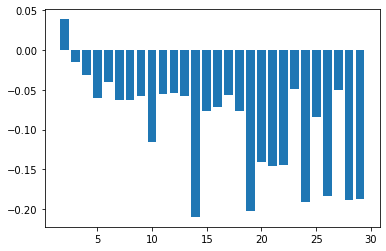

180-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3620      
_________________________________________________________________
dense_3 (Dense)              (None, 180)               3780      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 177,972
Trainable params: 177,972
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920

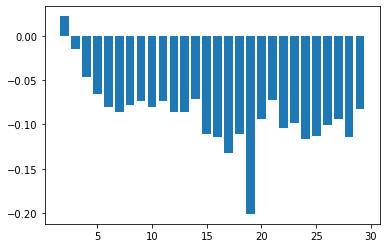

180-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               85140     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1810      
_________________________________________________________________
dense_3 (Dense)              (None, 180)               1980      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               85432     
Total params: 174,362
Trainable params: 174,362
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

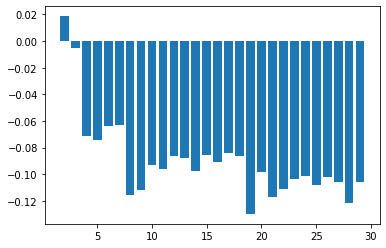

170-160dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               27360     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               27370     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 215,852
Trainable params: 215,852
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

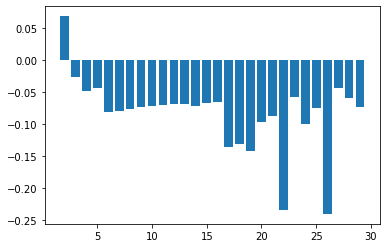

170-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               25650     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               25670     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 212,442
Trainable params: 212,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.688

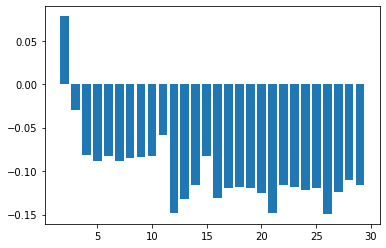

170-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               23940     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               23970     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 209,032
Trainable params: 209,032
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

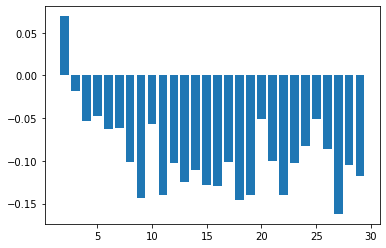

170-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               22230     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               22270     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 205,622
Trainable params: 205,622
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

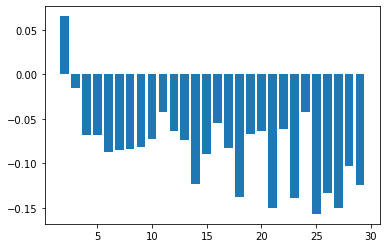

170-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               20520     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               20570     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 202,212
Trainable params: 202,212
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

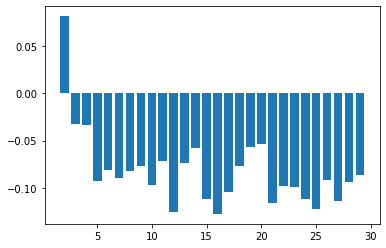

170-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               18810     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               18870     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 198,802
Trainable params: 198,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.690

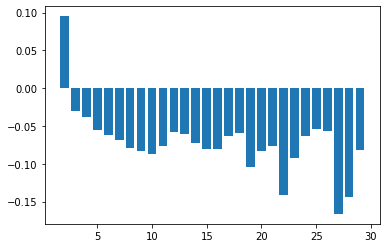

170-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               17100     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               17170     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 195,392
Trainable params: 195,392
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

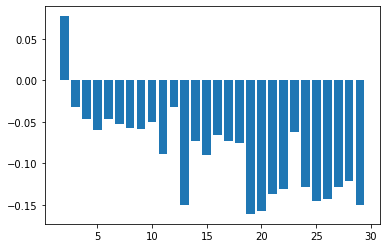

170-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                15390     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               15470     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 191,982
Trainable params: 191,982
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

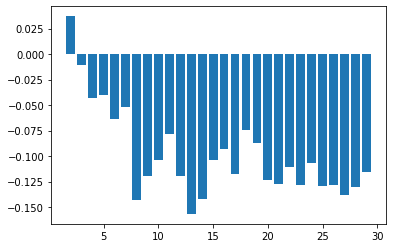

170-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                13680     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               13770     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 188,572
Trainable params: 188,572
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

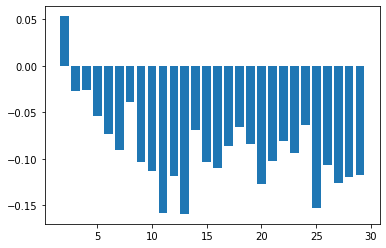

170-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                11970     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               12070     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 185,162
Trainable params: 185,162
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6906

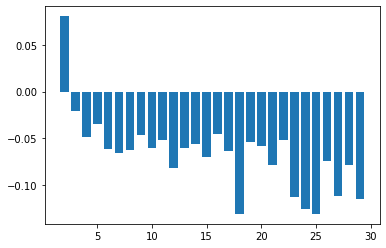

170-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                10260     
_________________________________________________________________
dense_3 (Dense)              (None, 170)               10370     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 181,752
Trainable params: 181,752
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6909

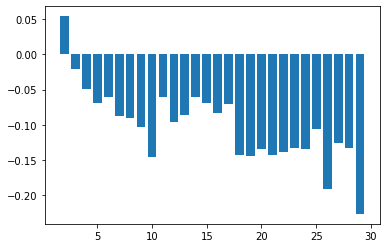

170-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                8550      
_________________________________________________________________
dense_3 (Dense)              (None, 170)               8670      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 178,342
Trainable params: 178,342
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

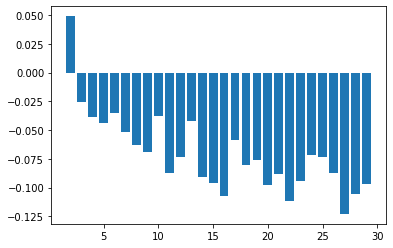

170-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                6840      
_________________________________________________________________
dense_3 (Dense)              (None, 170)               6970      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 174,932
Trainable params: 174,932
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

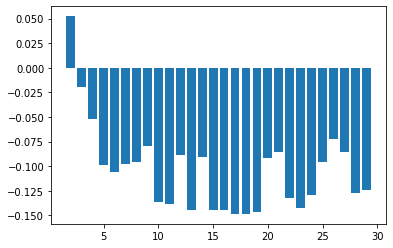

170-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                5130      
_________________________________________________________________
dense_3 (Dense)              (None, 170)               5270      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 171,522
Trainable params: 171,522
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6916

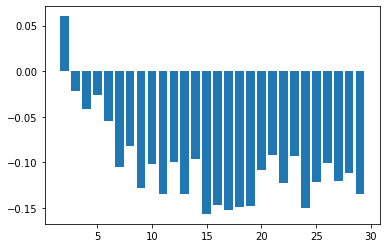

170-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3420      
_________________________________________________________________
dense_3 (Dense)              (None, 170)               3570      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 168,112
Trainable params: 168,112
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

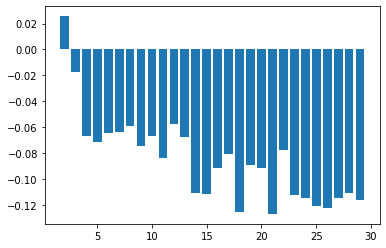

170-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 170)               80410     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1710      
_________________________________________________________________
dense_3 (Dense)              (None, 170)               1870      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               80712     
Total params: 164,702
Trainable params: 164,702
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922

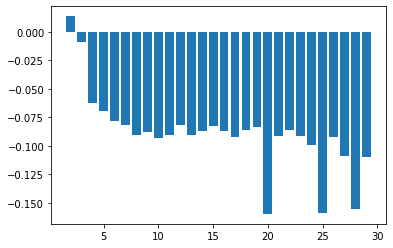

160-150dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               24150     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               24160     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 199,982
Trainable params: 199,982
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.691

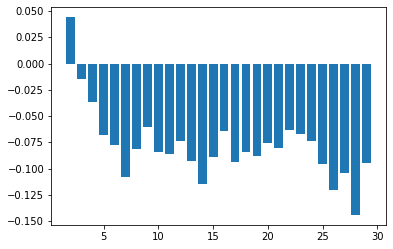

160-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               22540     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               22560     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 196,772
Trainable params: 196,772
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

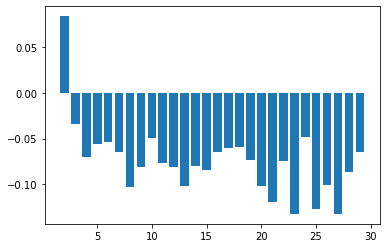

160-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               20930     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               20960     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 193,562
Trainable params: 193,562
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

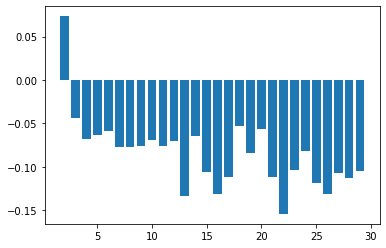

160-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               19320     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               19360     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 190,352
Trainable params: 190,352
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

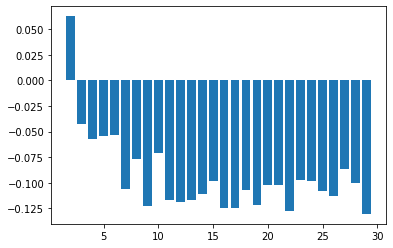

160-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               17710     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               17760     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 187,142
Trainable params: 187,142
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

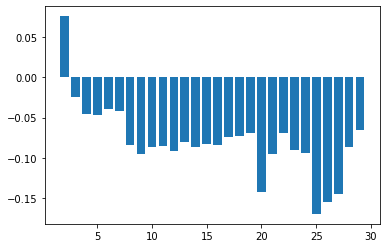

160-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               16100     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               16160     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 183,932
Trainable params: 183,932
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

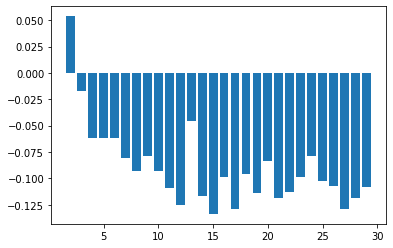

160-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                14490     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 180,722
Trainable params: 180,722
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6909

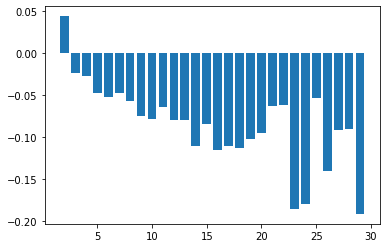

160-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                12880     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               12960     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 177,512
Trainable params: 177,512
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6909

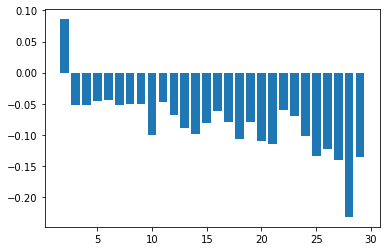

160-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                11270     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               11360     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 174,302
Trainable params: 174,302
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

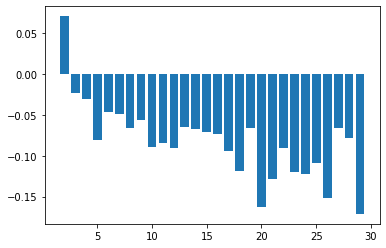

160-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                9660      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               9760      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 171,092
Trainable params: 171,092
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6906

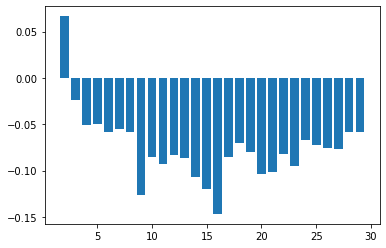

160-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                8050      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               8160      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 167,882
Trainable params: 167,882
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918

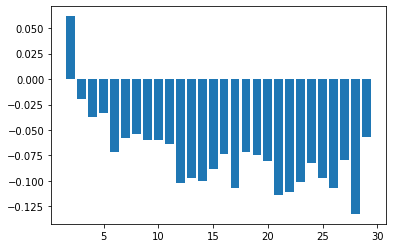

160-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                6440      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               6560      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 164,672
Trainable params: 164,672
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6911

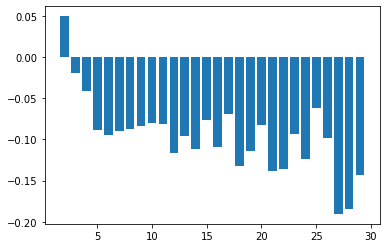

160-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                4830      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               4960      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 161,462
Trainable params: 161,462
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

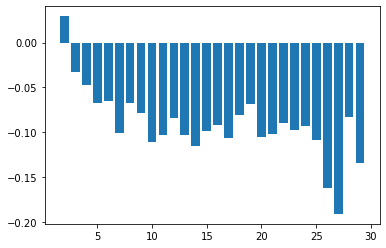

160-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3220      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               3360      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 158,252
Trainable params: 158,252
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

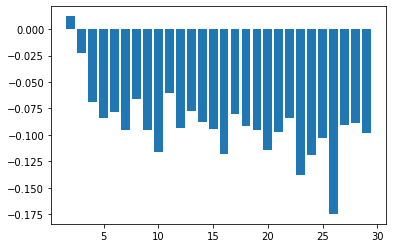

160-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               75680     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1610      
_________________________________________________________________
dense_3 (Dense)              (None, 160)               1760      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               75992     
Total params: 155,042
Trainable params: 155,042
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918

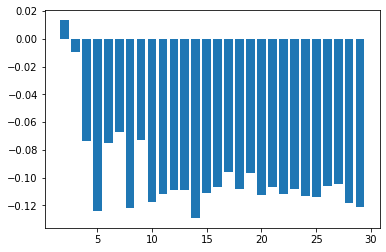

150-140dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 140)               21140     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               21150     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 184,512
Trainable params: 184,512
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

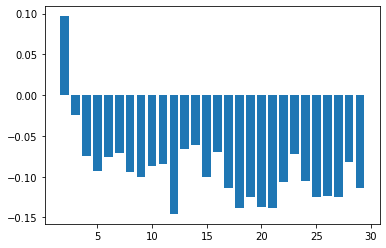

150-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               19630     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               19650     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 181,502
Trainable params: 181,502
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

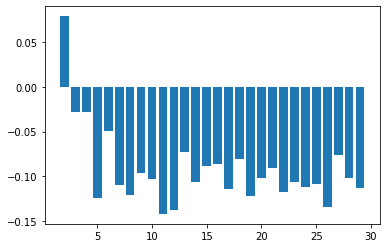

150-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               18120     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               18150     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 178,492
Trainable params: 178,492
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

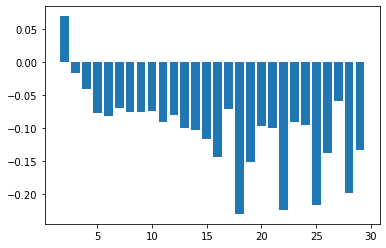

150-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               16610     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               16650     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 175,482
Trainable params: 175,482
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.692

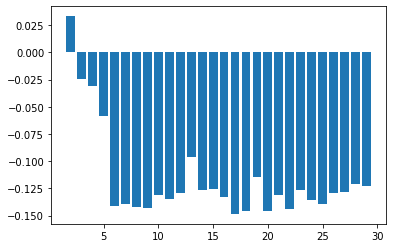

150-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 172,472
Trainable params: 172,472
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

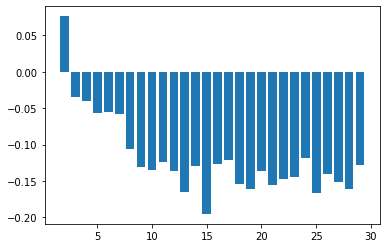

150-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                13590     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               13650     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 169,462
Trainable params: 169,462
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6913

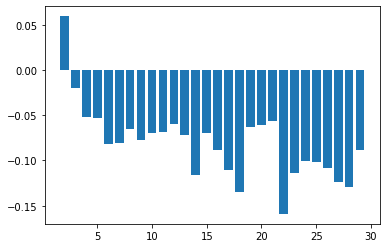

150-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                12080     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               12150     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 166,452
Trainable params: 166,452
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6897

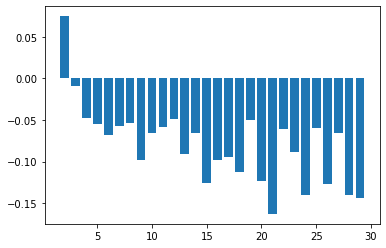

150-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                10570     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               10650     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 163,442
Trainable params: 163,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6909

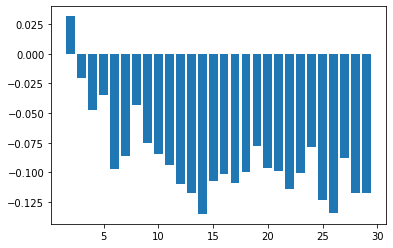

150-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                9060      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               9150      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 160,432
Trainable params: 160,432
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6919

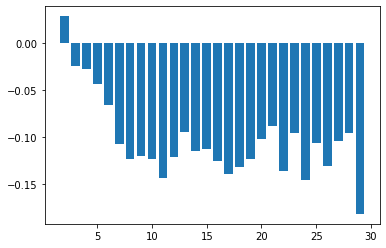

150-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 157,422
Trainable params: 157,422
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

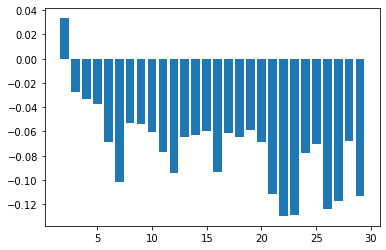

150-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                6040      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               6150      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 154,412
Trainable params: 154,412
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918

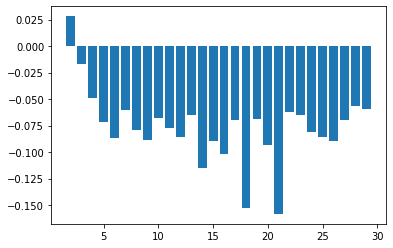

150-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                4530      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               4650      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 151,402
Trainable params: 151,402
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6915

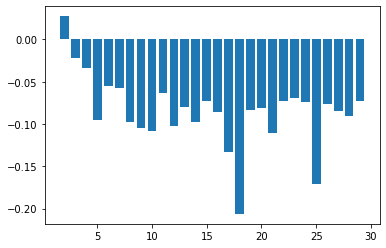

150-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3020      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               3150      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 148,392
Trainable params: 148,392
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

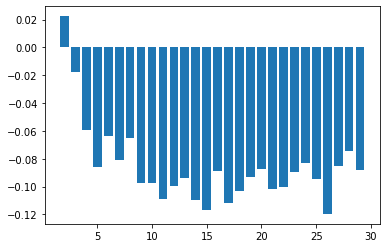

150-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               70950     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_3 (Dense)              (None, 150)               1650      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               71272     
Total params: 145,382
Trainable params: 145,382
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6926

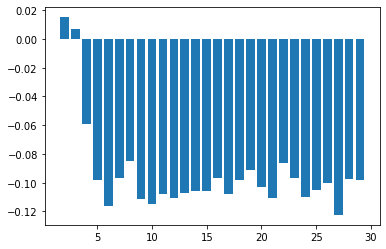

140-130dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 130)               18330     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               18340     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 169,442
Trainable params: 169,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

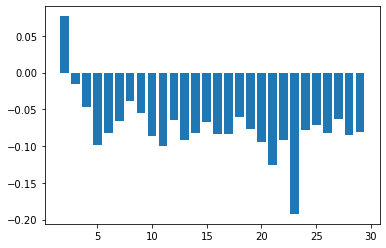

140-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               16920     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               16940     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 166,632
Trainable params: 166,632
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

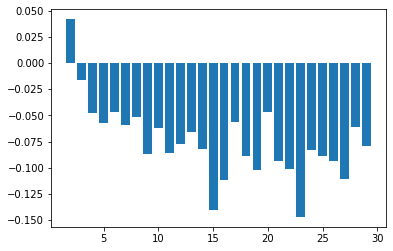

140-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               15510     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               15540     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 163,822
Trainable params: 163,822
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

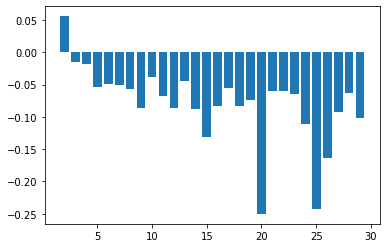

140-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               14140     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 161,012
Trainable params: 161,012
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.692

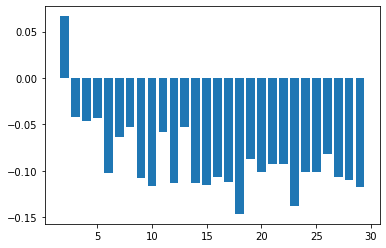

140-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                12690     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               12740     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 158,202
Trainable params: 158,202
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6913

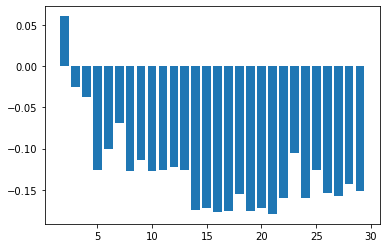

140-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                11280     
_________________________________________________________________
dense_3 (Dense)              (None, 140)               11340     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 155,392
Trainable params: 155,392
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6927

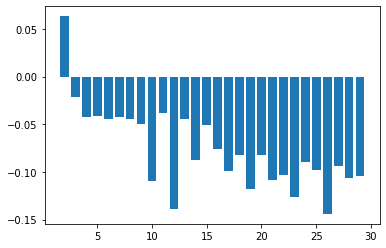

140-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                9870      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               9940      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 152,582
Trainable params: 152,582
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6928

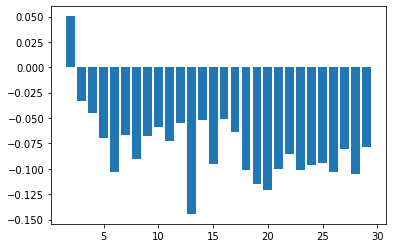

140-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                8460      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               8540      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 149,772
Trainable params: 149,772
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

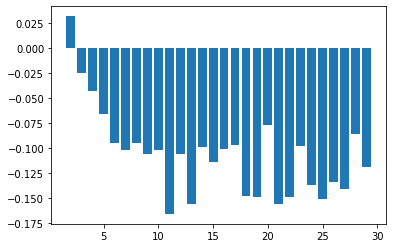

140-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                7050      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               7140      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 146,962
Trainable params: 146,962
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6903

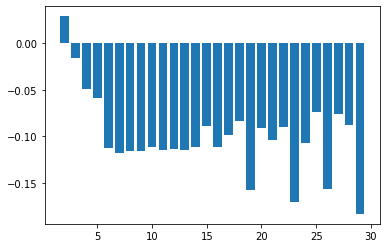

140-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5640      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               5740      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 144,152
Trainable params: 144,152
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6908

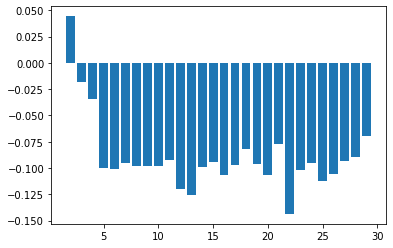

140-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                4230      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               4340      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 141,342
Trainable params: 141,342
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

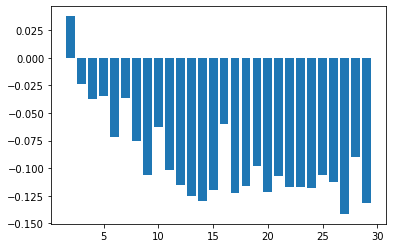

140-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2820      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               2940      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 138,532
Trainable params: 138,532
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

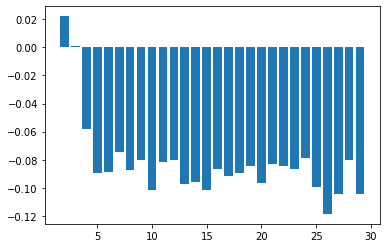

140-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 140)               66220     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1410      
_________________________________________________________________
dense_3 (Dense)              (None, 140)               1540      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               66552     
Total params: 135,722
Trainable params: 135,722
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

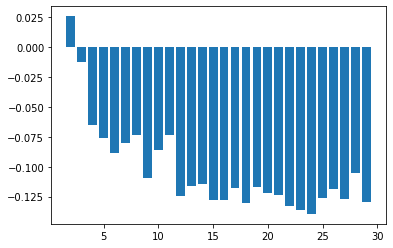

130-120dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               15720     
_________________________________________________________________
dense_3 (Dense)              (None, 130)               15730     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 154,772
Trainable params: 154,772
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

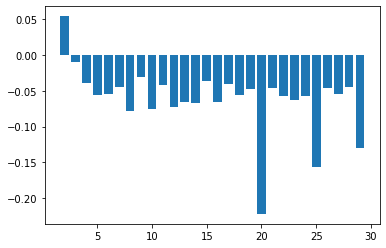

130-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               14410     
_________________________________________________________________
dense_3 (Dense)              (None, 130)               14430     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 152,162
Trainable params: 152,162
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.691

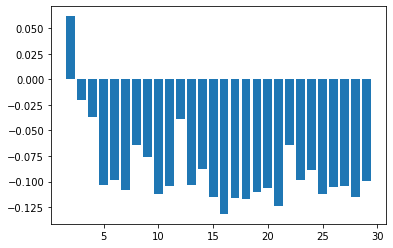

130-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               13100     
_________________________________________________________________
dense_3 (Dense)              (None, 130)               13130     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 149,552
Trainable params: 149,552
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.691

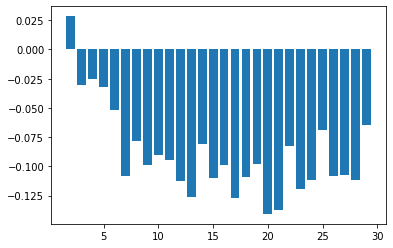

130-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                11790     
_________________________________________________________________
dense_3 (Dense)              (None, 130)               11830     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 146,942
Trainable params: 146,942
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6906

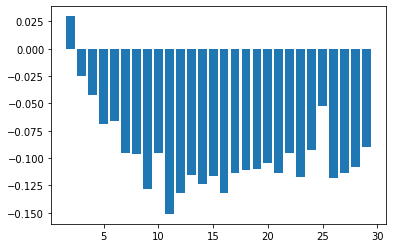

130-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                10480     
_________________________________________________________________
dense_3 (Dense)              (None, 130)               10530     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 144,332
Trainable params: 144,332
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

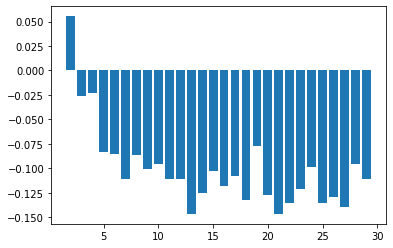

130-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                9170      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               9230      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 141,722
Trainable params: 141,722
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6903

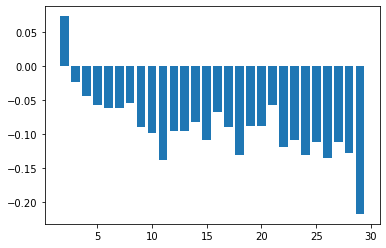

130-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7860      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               7930      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 139,112
Trainable params: 139,112
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6906

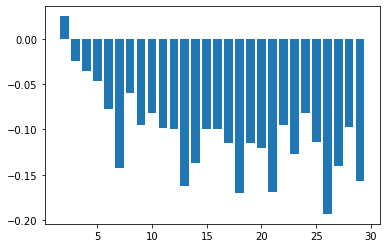

130-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6550      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               6630      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 136,502
Trainable params: 136,502
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

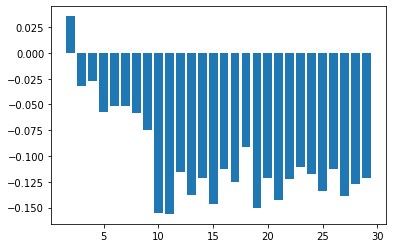

130-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5240      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               5330      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 133,892
Trainable params: 133,892
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912

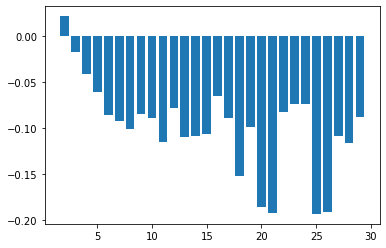

130-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3930      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               4030      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 131,282
Trainable params: 131,282
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6911

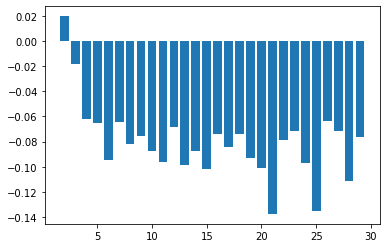

130-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2620      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               2730      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 128,672
Trainable params: 128,672
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6915

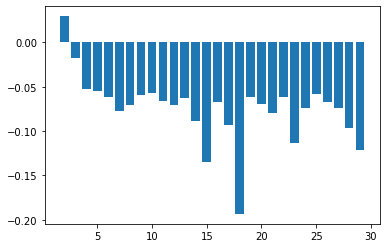

130-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               61490     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1310      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               1430      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               61832     
Total params: 126,062
Trainable params: 126,062
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922

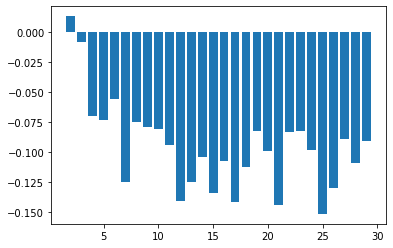

120-110dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               13310     
_________________________________________________________________
dense_3 (Dense)              (None, 120)               13320     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 140,502
Trainable params: 140,502
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

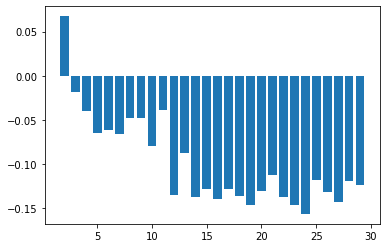

120-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12100     
_________________________________________________________________
dense_3 (Dense)              (None, 120)               12120     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 138,092
Trainable params: 138,092
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.692

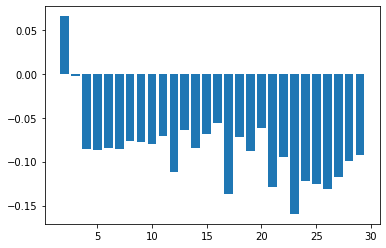

120-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                10890     
_________________________________________________________________
dense_3 (Dense)              (None, 120)               10920     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 135,682
Trainable params: 135,682
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

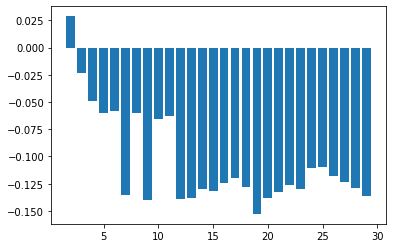

120-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               9720      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 133,272
Trainable params: 133,272
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6902

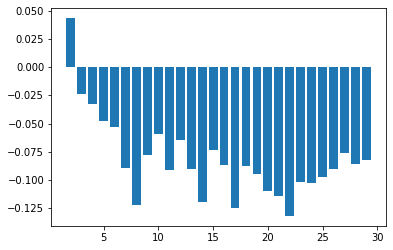

120-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                8470      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               8520      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 130,862
Trainable params: 130,862
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6910

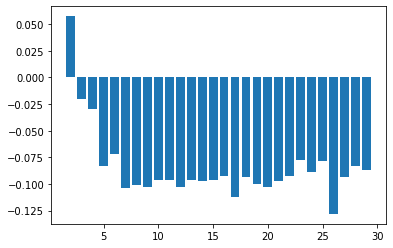

120-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 128,452
Trainable params: 128,452
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6926

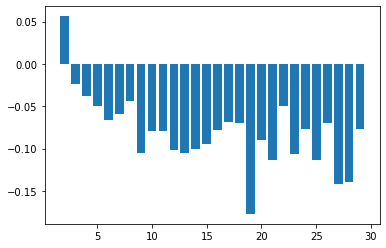

120-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6050      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               6120      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 126,042
Trainable params: 126,042
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923

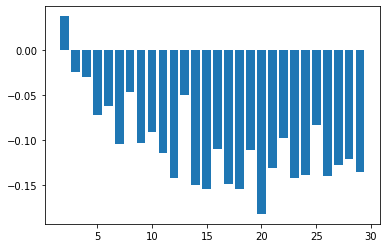

120-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4840      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               4920      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 123,632
Trainable params: 123,632
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922

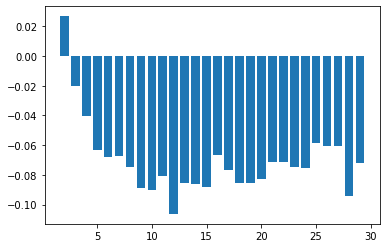

120-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3630      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               3720      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 121,222
Trainable params: 121,222
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6914

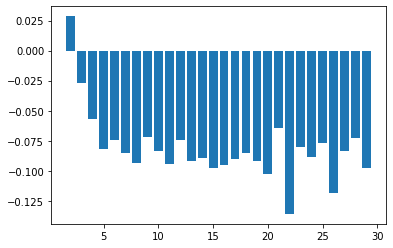

120-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2420      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               2520      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 118,812
Trainable params: 118,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6919

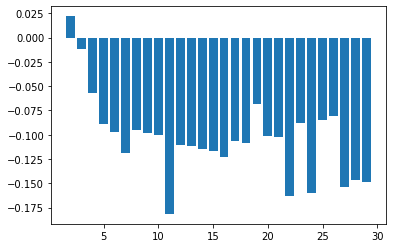

120-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               56760     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1210      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               1320      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               57112     
Total params: 116,402
Trainable params: 116,402
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922

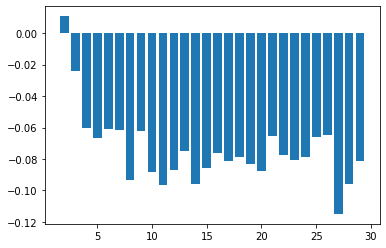

110-100dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               11100     
_________________________________________________________________
dense_3 (Dense)              (None, 110)               11110     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 126,632
Trainable params: 126,632
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.690

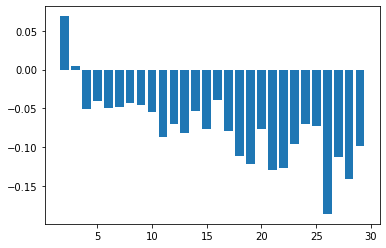

110-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                9990      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               10010     
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 124,422
Trainable params: 124,422
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6909

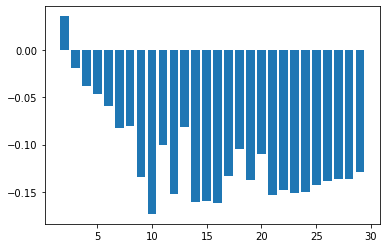

110-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8880      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               8910      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 122,212
Trainable params: 122,212
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922

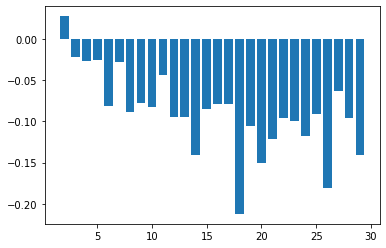

110-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                7770      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               7810      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 120,002
Trainable params: 120,002
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6909

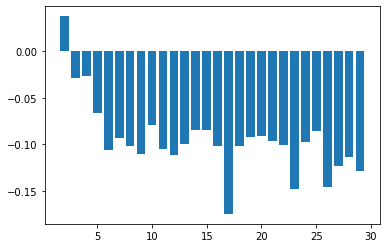

110-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6660      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               6710      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 117,792
Trainable params: 117,792
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6915

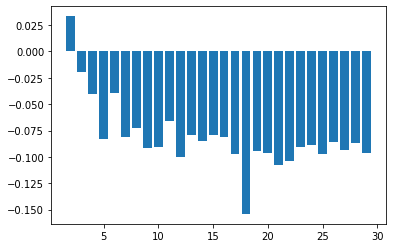

110-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5550      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               5610      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 115,582
Trainable params: 115,582
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921

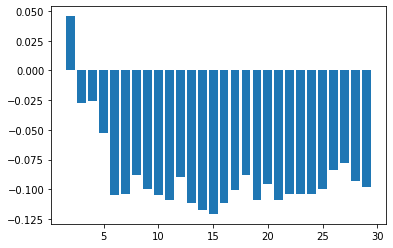

110-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4440      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               4510      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 113,372
Trainable params: 113,372
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920

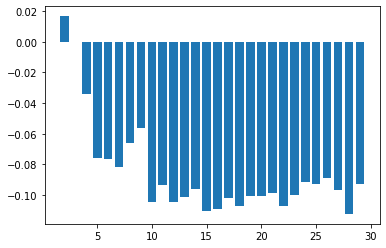

110-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3330      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               3410      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 111,162
Trainable params: 111,162
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917

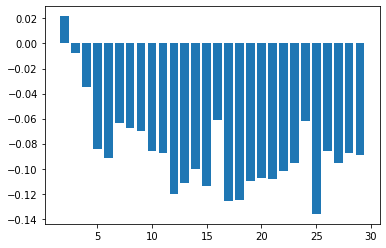

110-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2220      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               2310      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 108,952
Trainable params: 108,952
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921

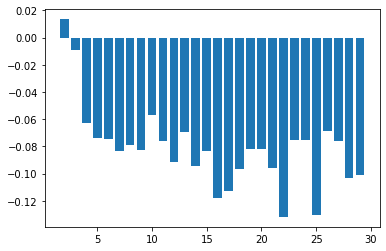

110-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               52030     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1110      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               1210      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               52392     
Total params: 106,742
Trainable params: 106,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6924

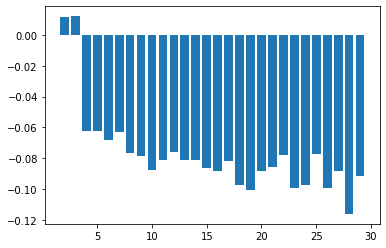

100-90dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                9090      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6911

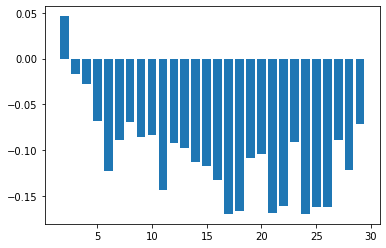

100-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 111,152
Trainable params: 111,152
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918

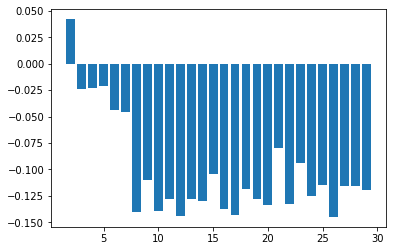

100-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               7100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 109,142
Trainable params: 109,142
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6908

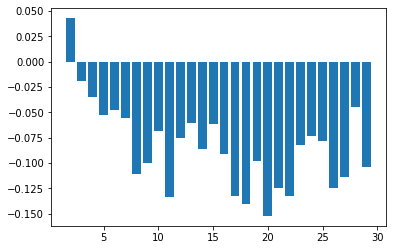

100-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 107,132
Trainable params: 107,132
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923

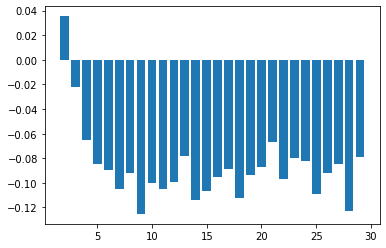

100-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 105,122
Trainable params: 105,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6915

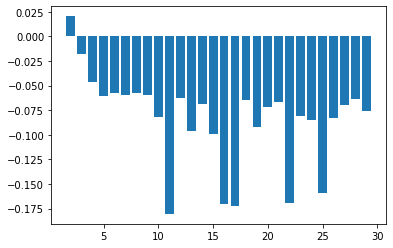

100-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 103,112
Trainable params: 103,112
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6928

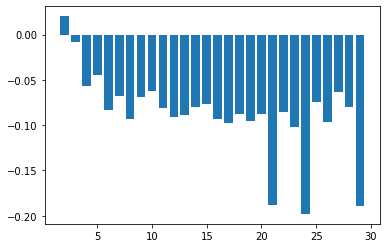

100-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 101,102
Trainable params: 101,102
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918

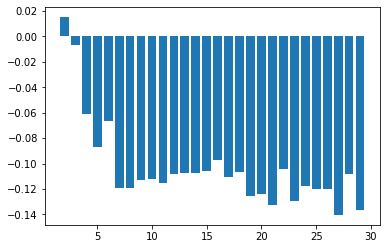

100-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 99,092
Trainable params: 99,092
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920 -

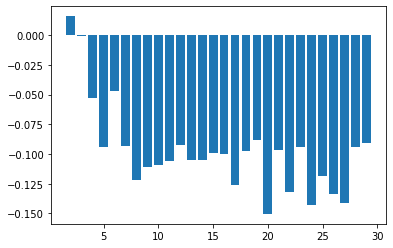

100-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 97,082
Trainable params: 97,082
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922 -

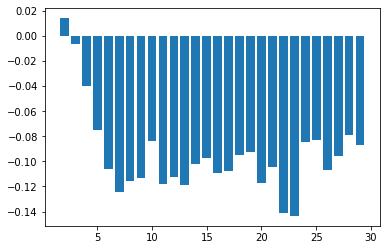

90-80dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                7280      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                7290      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 100,092
Trainable params: 100,092
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6907 

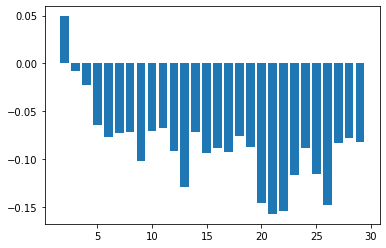

90-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                6370      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                6390      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 98,282
Trainable params: 98,282
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6913 - 

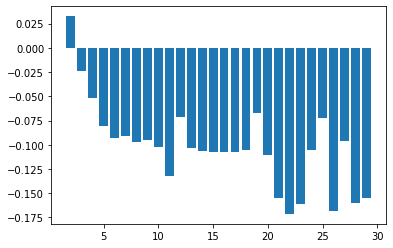

90-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                5490      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 96,472
Trainable params: 96,472
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6911 - 

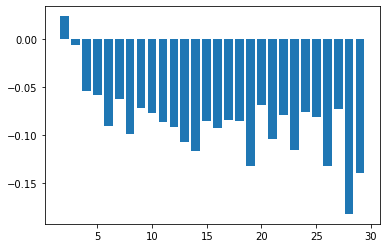

90-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                4590      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 94,662
Trainable params: 94,662
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6917 - 

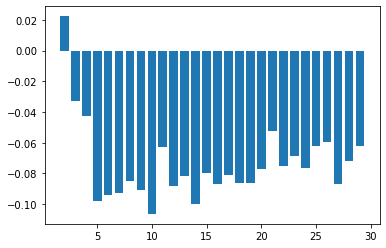

90-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3640      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                3690      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 92,852
Trainable params: 92,852
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6909 - 

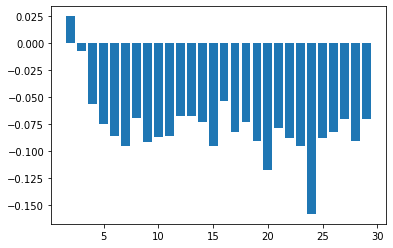

90-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                2790      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 91,042
Trainable params: 91,042
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918 - 

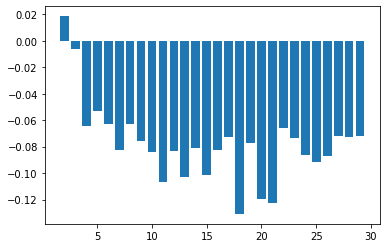

90-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1820      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                1890      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 89,232
Trainable params: 89,232
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6925 - 

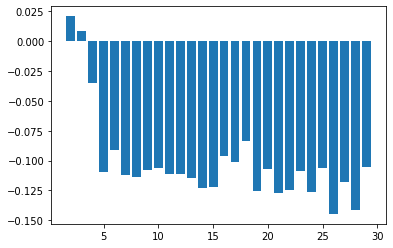

90-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                910       
_________________________________________________________________
dense_3 (Dense)              (None, 90)                990       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 87,422
Trainable params: 87,422
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923 - 

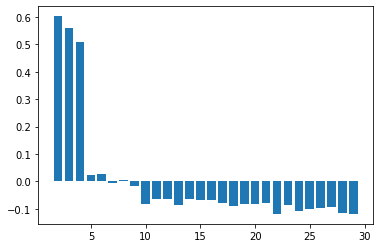

80-70dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 70)                5670      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                5680      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 87,422
Trainable params: 87,422
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922 - 

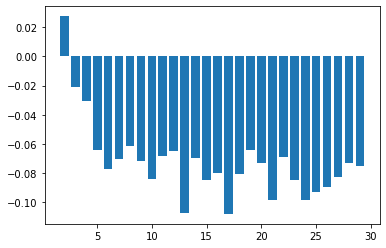

80-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4880      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 85,812
Trainable params: 85,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6912 - 

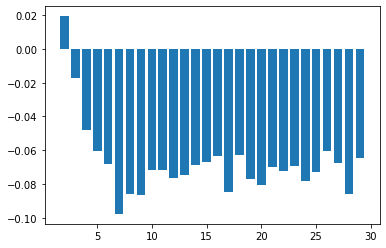

80-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 84,202
Trainable params: 84,202
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6925 - 

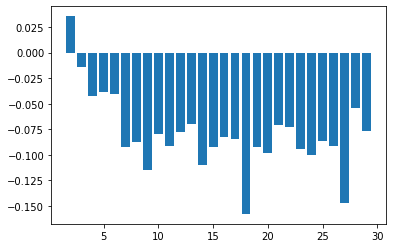

80-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 82,592
Trainable params: 82,592
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920 - 

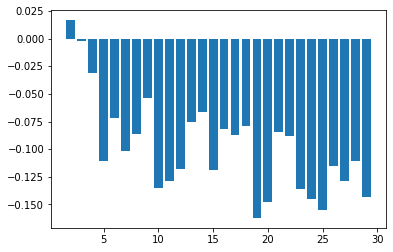

80-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 80,982
Trainable params: 80,982
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921 - 

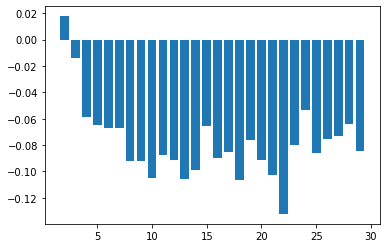

80-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 79,372
Trainable params: 79,372
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6919 - 

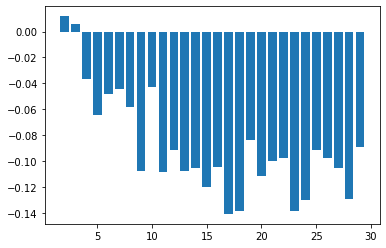

80-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                810       
_________________________________________________________________
dense_3 (Dense)              (None, 80)                880       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 77,762
Trainable params: 77,762
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6916 - 

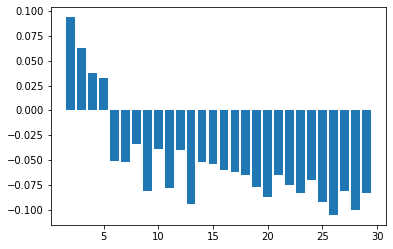

70-60dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                4270      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 75,152
Trainable params: 75,152
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6917 - 

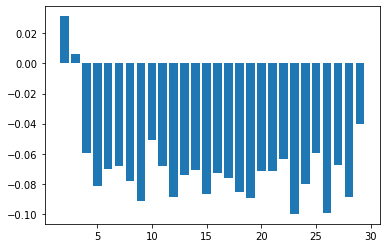

70-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                3570      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 73,742
Trainable params: 73,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6916 - 

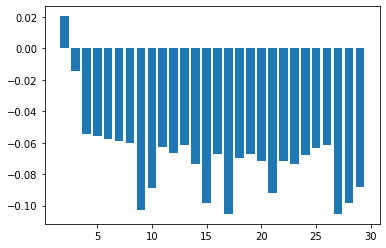

70-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2840      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                2870      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 72,332
Trainable params: 72,332
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921 - 

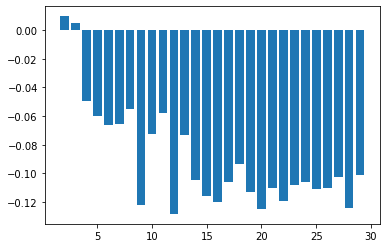

70-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                2170      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 70,922
Trainable params: 70,922
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921 - 

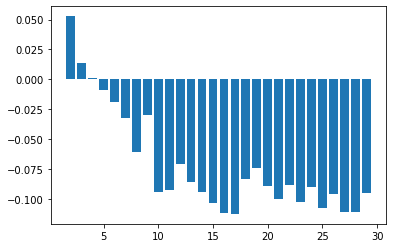

70-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1420      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                1470      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 69,512
Trainable params: 69,512
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6927 - 

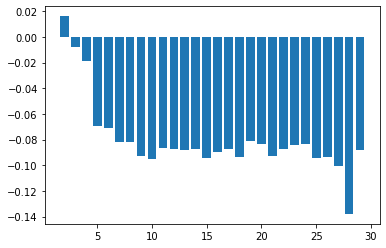

70-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                710       
_________________________________________________________________
dense_3 (Dense)              (None, 70)                770       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 68,102
Trainable params: 68,102
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6920 - 

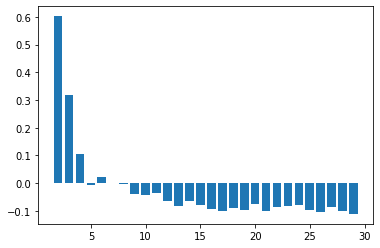

60-50dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 63,282
Trainable params: 63,282
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6927 - 

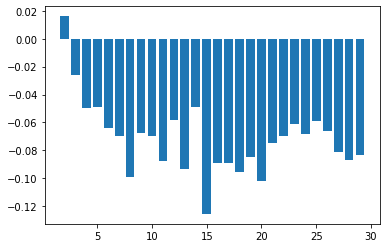

60-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 62,072
Trainable params: 62,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6926 - 

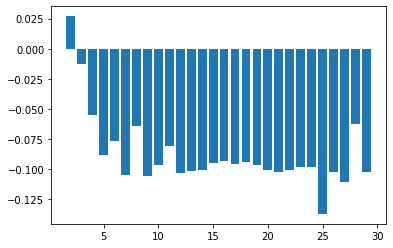

60-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 60,862
Trainable params: 60,862
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923 - 

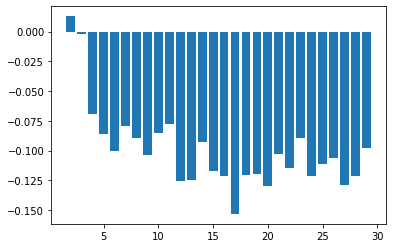

60-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 59,652
Trainable params: 59,652
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922 - 

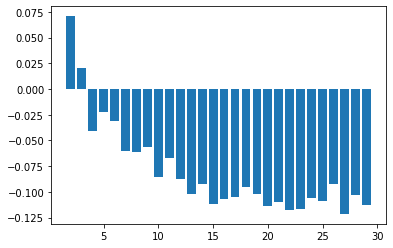

60-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                610       
_________________________________________________________________
dense_3 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 58,442
Trainable params: 58,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6928 - 

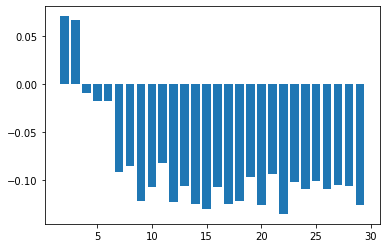

50-40dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 51,812
Trainable params: 51,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6921 - 

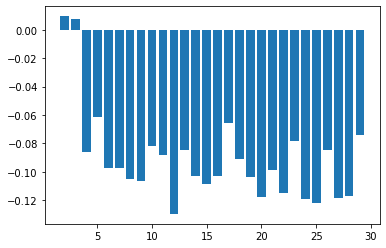

50-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 50,802
Trainable params: 50,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6923 - 

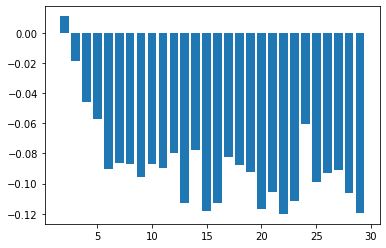

50-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918 - 

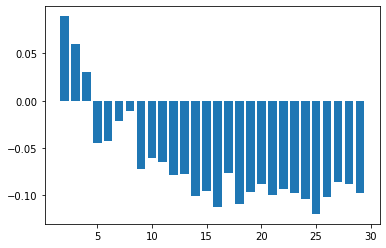

50-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 48,782
Trainable params: 48,782
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6926 - 

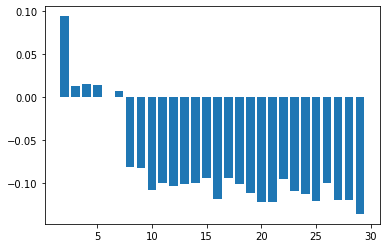

40-30dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 40,742
Trainable params: 40,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6927 - 

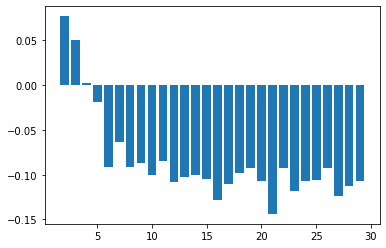

40-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 39,932
Trainable params: 39,932
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6922 - 

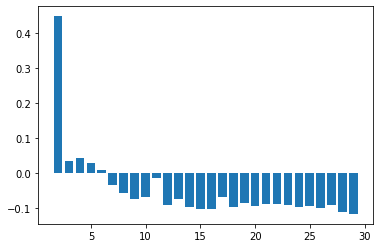

40-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 39,122
Trainable params: 39,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6918 - 

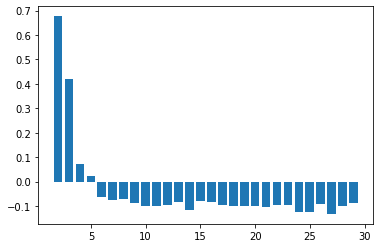

30-20dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 30,072
Trainable params: 30,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6928 - 

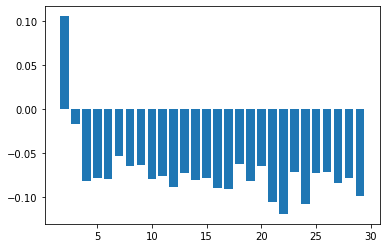

30-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 29,462
Trainable params: 29,462
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6929 - 

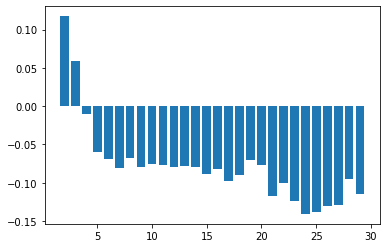

20-10dim
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                9460      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               9912      
Total params: 19,802
Trainable params: 19,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 0.6921 - 

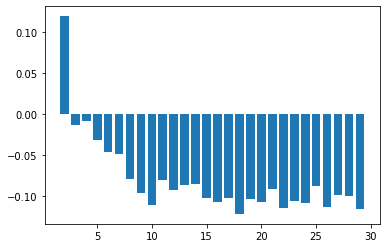

In [17]:
# Grid search
for middle_dim in search_list[19:]:
    for encoding_dim in search_list[search_list.index(middle_dim) + 1:]:
        training(middle_dim, encoding_dim)

# Silhouette Score 

In [18]:
ls = os.listdir('./score/grid/')
ls.sort()
ls

['100-10dim.json',
 '100-20dim.json',
 '100-30dim.json',
 '100-40dim.json',
 '100-50dim.json',
 '100-60dim.json',
 '100-70dim.json',
 '100-80dim.json',
 '100-90dim.json',
 '110-100dim.json',
 '110-10dim.json',
 '110-20dim.json',
 '110-30dim.json',
 '110-40dim.json',
 '110-50dim.json',
 '110-60dim.json',
 '110-70dim.json',
 '110-80dim.json',
 '110-90dim.json',
 '120-100dim.json',
 '120-10dim.json',
 '120-110dim.json',
 '120-20dim.json',
 '120-30dim.json',
 '120-40dim.json',
 '120-50dim.json',
 '120-60dim.json',
 '120-70dim.json',
 '120-80dim.json',
 '120-90dim.json',
 '130-100dim.json',
 '130-10dim.json',
 '130-110dim.json',
 '130-120dim.json',
 '130-20dim.json',
 '130-30dim.json',
 '130-40dim.json',
 '130-50dim.json',
 '130-60dim.json',
 '130-70dim.json',
 '130-80dim.json',
 '130-90dim.json',
 '140-100dim.json',
 '140-10dim.json',
 '140-110dim.json',
 '140-120dim.json',
 '140-130dim.json',
 '140-20dim.json',
 '140-30dim.json',
 '140-40dim.json',
 '140-50dim.json',
 '140-60dim.json',
 '

In [21]:
rows = []
for file in ls:
    name = file.split('.')[0]
    score = read_json('./score/grid/' + file)
    rows.append([name] + score)

In [22]:
score_df = pd.DataFrame(rows, columns = range(1, 30))
score_df

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,100-10dim,0.014155,-0.006332,-0.040053,-0.074923,-0.105904,-0.124036,-0.115262,-0.113009,-0.083699,...,-0.117311,-0.104764,-0.141165,-0.143457,-0.084325,-0.083084,-0.106778,-0.095820,-0.078983,-0.086794
1,100-20dim,0.016032,-0.000759,-0.053215,-0.093773,-0.046555,-0.092943,-0.121718,-0.110608,-0.108894,...,-0.150480,-0.096487,-0.132222,-0.094452,-0.143210,-0.118142,-0.133897,-0.141163,-0.094399,-0.090424
2,100-30dim,0.014999,-0.006851,-0.060697,-0.087120,-0.066771,-0.119586,-0.118893,-0.112839,-0.112268,...,-0.123988,-0.132926,-0.104360,-0.129423,-0.117244,-0.120086,-0.119688,-0.140358,-0.108562,-0.136853
3,100-40dim,0.020197,-0.008445,-0.057333,-0.044771,-0.083267,-0.068144,-0.093495,-0.069205,-0.061987,...,-0.088063,-0.187920,-0.084968,-0.101920,-0.197958,-0.074919,-0.096209,-0.063943,-0.080035,-0.189212
4,100-50dim,0.020566,-0.018139,-0.046440,-0.060968,-0.056974,-0.059073,-0.057439,-0.059238,-0.081570,...,-0.072088,-0.066948,-0.169418,-0.081300,-0.085059,-0.159524,-0.082924,-0.069932,-0.063141,-0.076020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,90-40dim,0.025101,-0.007429,-0.056427,-0.074997,-0.085717,-0.095391,-0.069005,-0.091065,-0.086593,...,-0.117291,-0.078954,-0.087488,-0.094738,-0.158135,-0.087332,-0.082512,-0.070370,-0.090180,-0.070253
776,90-50dim,0.022352,-0.033126,-0.042607,-0.097861,-0.094215,-0.092958,-0.085053,-0.090651,-0.106363,...,-0.076864,-0.052334,-0.075458,-0.068720,-0.076552,-0.062096,-0.059789,-0.087150,-0.071988,-0.062172
777,90-60dim,0.023678,-0.006664,-0.053997,-0.058500,-0.091075,-0.062365,-0.099061,-0.071678,-0.077002,...,-0.068634,-0.104244,-0.079609,-0.115474,-0.076063,-0.080939,-0.132264,-0.072703,-0.182479,-0.140014
778,90-70dim,0.032637,-0.024184,-0.051523,-0.080221,-0.092616,-0.091450,-0.097212,-0.095544,-0.102728,...,-0.110090,-0.154696,-0.171372,-0.161330,-0.104946,-0.072767,-0.167852,-0.096256,-0.160167,-0.154498


In [23]:
score_df.to_csv('./output/score_df_grid.csv', index = 0)